In [0]:
import pickle
import numpy as np
import pandas as pd
import torch
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        # если выборка для тренировки сети, проводим аугментацию
        else:
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomChoice(
                                  [transforms.ColorJitter(0.5, 0.5),
                                  transforms.RandomPerspective(),
                                  transforms.RandomGrayscale(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(180)]),
                transforms.RandomChoice(
                                  [transforms.ColorJitter(0.5, 0.5),
                                  transforms.RandomPerspective(),
                                  transforms.RandomGrayscale(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(180)]),        
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!unzip -q /content/gdrive/My\ Drive/dls/кегл_симпсоны/journey-springfield.zip -d all

In [0]:
!ls all

characters_illustration.png  sample_submission.csv  testset  train


In [0]:
import os
import shutil

TRAIN_DIR = Path('all/train/simpsons_dataset')
TEST_DIR = Path('all/testset/testset')

              
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 1000:
        dct_path_train[person] = dct_path_train[person] * (1000 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:1000 - len(dct_path_train[person])])

# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")



new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

abraham_grampa_simpson	1000
agnes_skinner	1000
apu_nahasapeemapetilon	1000
barney_gumble	1000
bart_simpson	1006
carl_carlson	1000
charles_montgomery_burns	1000
chief_wiggum	1000
cletus_spuckler	1000
comic_book_guy	1000
disco_stu	1000
edna_krabappel	1000
fat_tony	1000
gil	1000
groundskeeper_willie	1000
homer_simpson	1684
kent_brockman	1000
krusty_the_clown	1000
lenny_leonard	1000
lionel_hutz	1000
lisa_simpson	1015
maggie_simpson	1000
marge_simpson	1000
martin_prince	1000
mayor_quimby	1000
milhouse_van_houten	1000
miss_hoover	1000
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	1000
otto_mann	1000
patty_bouvier	1000
principal_skinner	1000
professor_john_frink	1000
rainier_wolfcastle	1000
ralph_wiggum	1000
selma_bouvier	1000
sideshow_bob	1000
sideshow_mel	1000
snake_jailbird	1000
troy_mcclure	1000
waylon_smithers	1000


In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

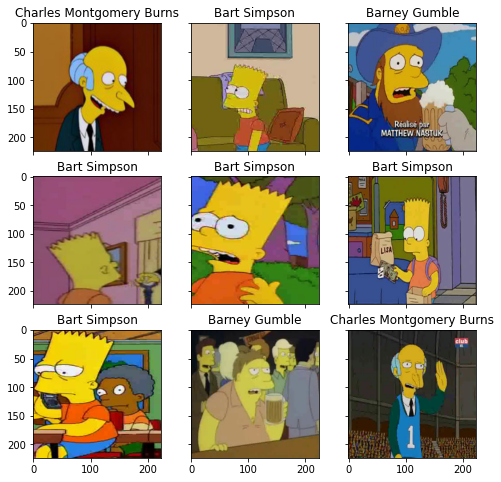

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # заменяем исходный lr, добавляем scheduler
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size = 5, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [0]:
classes_number = 42

Ансамбль



In [0]:
class MyEnsemble(nn.Module):   
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(classes_number * 2, classes_number)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.classifier(x)
        return x

In [0]:
model1 = models.resnet34(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, 42)
model1 = model1.to(DEVICE)

model2 = models.resnet34(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 42)
model2 = model1.to(DEVICE)

In [0]:
model1_path = '/content/gdrive/My Drive/dls/models/model1_weights_fromkaggle.pth'
model2_path = '/content/gdrive/My Drive/dls/models/model2_weights_fromkaggle.pth'

In [0]:
# Загружаем state dicts
model1.load_state_dict(torch.load(model1_path))
model2.load_state_dict(torch.load(model2_path))

<All keys matched successfully>

In [0]:
model_ensemble = MyEnsemble(model1, model2)
model_ensemble = model_ensemble.to(DEVICE)

In [0]:
# замораживаем параметры (веса) не входящие в layers_to_unfreeze
for param in model_ensemble.parameters():
    param.requires_grad = False

for param in model_ensemble.classifier.parameters():
    param.requires_grad = True

In [0]:
history = train(train_dataset, val_dataset, model=model_ensemble, epochs=10, batch_size=32)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.8705166082422751


epoch:  10%|█         | 1/10 [03:23<30:34, 203.81s/it]


Epoch 001 train_loss: 0.8705     val_loss 0.2271 train_acc 0.8260 val_acc 0.9471
loss 0.2413528645594444


epoch:  20%|██        | 2/10 [06:45<27:06, 203.32s/it]


Epoch 002 train_loss: 0.2414     val_loss 0.1682 train_acc 0.9457 val_acc 0.9614
loss 0.1915521087890575


epoch:  30%|███       | 3/10 [10:08<23:42, 203.17s/it]


Epoch 003 train_loss: 0.1916     val_loss 0.1509 train_acc 0.9546 val_acc 0.9658
loss 0.1683705273240423


epoch:  40%|████      | 4/10 [13:31<20:17, 202.91s/it]


Epoch 004 train_loss: 0.1684     val_loss 0.1439 train_acc 0.9583 val_acc 0.9643
loss 0.15352198579396378


epoch:  50%|█████     | 5/10 [16:52<16:51, 202.33s/it]


Epoch 005 train_loss: 0.1535     val_loss 0.1394 train_acc 0.9617 val_acc 0.9668
loss 0.1437700940281223


epoch:  60%|██████    | 6/10 [20:14<13:29, 202.44s/it]


Epoch 006 train_loss: 0.1438     val_loss 0.1355 train_acc 0.9642 val_acc 0.9671
loss 0.14161968930556262


epoch:  70%|███████   | 7/10 [23:36<10:07, 202.35s/it]


Epoch 007 train_loss: 0.1416     val_loss 0.1362 train_acc 0.9640 val_acc 0.9673


epoch:  70%|███████   | 7/10 [24:18<10:24, 208.30s/it]


KeyboardInterrupt: ignored

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

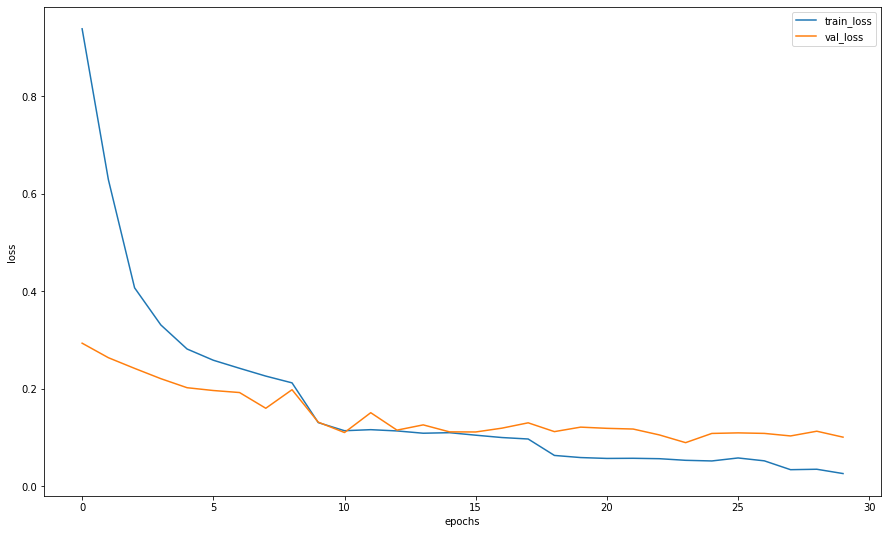

In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
name = 'model1_weights_fromkaggle.pth'
pat = F"/content/gdrive/My Drive/{name}"


In [0]:
torch.save(model.state_dict(), pat) 

In [0]:
!ls /content/gdrive/My\ Drive/dls/кегл_симпсоны

journey-springfield.zip  simp_kaggle_sol.ipynb
my_model.ipynb		 simpsons_baseline.ipynb


In [0]:
!ls /content/gdrive/My\ Drive

 12.xlsm
'Colab Notebooks'
 current.pdf
 dls
 model_weights.pth
 openedu
 Samsung_course
 паспорт.прописка.jpg
'Представление от работника (присвоение КНК)_Прием на работу.gdoc'


In [0]:
idxs = list(map(int, np.random.uniform(0,1000, 50)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [i for i in y_pred]
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='macro')

1.0

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:

submit.to_csv('/content/gdrive/My Drive/submission2.csv', index=False)